<div align='center'>

# <u> __Machine Learning Project__ </u>

## __-Predicting flight delays-__

_by:_

[Jan Fernando Bohlmann](https://github.com/janb89) ,[Tamara Pallien](https://github.com/tamap94) & [Frederic Baumeister](https://github.com/FredNoonienSingh)

___
___

</div>

## Content 
___

1. Introduction
     - 1.1 Stakeholder
     - 1.2 Business Case
     - 1.3 Evaluation metric 
2. Setup 
3. Data
4. Feature Engineering
5. Training the baseline model
6. finding the best hyperparameters
7. testing the model 
8. conclusion
9. Sources

## 1. Introduction 
____

### 1.1 Stakeholder - Tunisair 

Tunisair is an airline of Tunisia. Formed in 1948, it operates scheduled international services to four continents. Its main base is Tunis–Carthage International Airport. The airline's head office is in Tunis, near Tunis Airport. Tunisair is a member of the Arab Air Carriers Organization. Their fleet consists of 30 airplanes and the flight to city destinations. 

### 1.2 Business Case

The aim of the model is to predict flight delays in minutes.
The stakeholder could adapt to these delays by planning and reorganization of staff, equipment and planes or to find alternatives for certain airports with a bad management and organization team. Further, the predictions would enable a better communication with costumers, who are informed in advance about the potential delay of their flight. 

### 1.3 Evaluation Metric 

To predict the delay in minutes, a regression model will be used. Thus, the evaluation metric is the mean squared error, who gives information about how much the predicted values differ from the real values in the training dataset. The better this value, the closer the predicted delay times to the delay times that have been detected in the past years. 




## 2. Setup 
___

#### 2.1 importing the necessary modules

In [1]:

"""Data manipulation and visualization"""
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt 
%matplotlib inline
from matplotlib import figure 
import seaborn as sns


"""Machine Learning"""
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.experimental import enable_halving_search_cv
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.model_selection import GridSearchCV, HalvingGridSearchCV
from sklearn.model_selection import train_test_split

from sklearn.svm import SVR 
from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor

from sklearn.metrics import mean_squared_error


""" External APIs"""
import airportsdata
airports = airportsdata.load('IATA')


import warnings
warnings.filterwarnings('ignore')

RSEED = 42
figsize=(10, 10)

#### 2.2 creating X

In [2]:
# creating the Xs

df = pd.read_csv('data/Train.csv')

#### 2.3 creating target Vector 

In [3]:
X = df.drop('target', axis=1)
y = df['target']

In [4]:
print('Training Data:')
print(f'   Values in Feature Vector: {X.shape[0]}\n   Values in Target Vector: {y.shape[0]}')

Training Data:
   Values in Feature Vector: 107833
   Values in Target Vector: 107833


## 3. Data
____

#### 3.1 Overview of the Data

In [5]:
df.head(10)

,ID,DATOP,FLTID,DEPSTN,ARRSTN,STD,STA,STATUS,AC,target
0,train_id_0,2016-01-03,TU 0712,CMN,TUN,2016-01-03 10:30:00,2016-01-03 12.55.00,ATA,TU 32AIMN,260.0
1,train_id_1,2016-01-13,TU 0757,MXP,TUN,2016-01-13 15:05:00,2016-01-13 16.55.00,ATA,TU 31BIMO,20.0
2,train_id_2,2016-01-16,TU 0214,TUN,IST,2016-01-16 04:10:00,2016-01-16 06.45.00,ATA,TU 32AIMN,0.0
3,train_id_3,2016-01-17,TU 0480,DJE,NTE,2016-01-17 14:10:00,2016-01-17 17.00.00,ATA,TU 736IOK,0.0
4,train_id_4,2016-01-17,TU 0338,TUN,ALG,2016-01-17 14:30:00,2016-01-17 15.50.00,ATA,TU 320IMU,22.0
5,train_id_5,2016-01-17,TU 0283,TLS,TUN,2016-01-17 16:20:00,2016-01-17 18.15.00,ATA,TU 736IOP,53.0
6,train_id_6,2016-01-18,TU 0514,TUN,BCN,2016-01-18 07:15:00,2016-01-18 09.00.00,ATA,TU 32AIMH,10.0
7,train_id_7,2016-01-18,TU 0716,TUN,ORY,2016-01-18 07:35:00,2016-01-18 09.55.00,ATA,TU 32AIMI,15.0
8,train_id_8,2016-01-18,TU 0752,TUN,FCO,2016-01-18 07:40:00,2016-01-18 09.00.00,ATA,TU 32AIMC,16.0
9,train_id_9,2016-01-18,TU 0996,TUN,NCE,2016-01-18 07:45:00,2016-01-18 09.15.00,ATA,TU 31AIMK,21.0


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 107833 entries, 0 to 107832
Data columns (total 10 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   ID      107833 non-null  object 
 1   DATOP   107833 non-null  object 
 2   FLTID   107833 non-null  object 
 3   DEPSTN  107833 non-null  object 
 4   ARRSTN  107833 non-null  object 
 5   STD     107833 non-null  object 
 6   STA     107833 non-null  object 
 7   STATUS  107833 non-null  object 
 8   AC      107833 non-null  object 
 9   target  107833 non-null  float64
dtypes: float64(1), object(9)
memory usage: 8.2+ MB


In [7]:
df.isnull().sum()

ID        0
DATOP     0
FLTID     0
DEPSTN    0
ARRSTN    0
STD       0
STA       0
STATUS    0
AC        0
target    0
dtype: int64

#### 3.2 Basic Data Cleaning 

As a first Step, we will convert all strings that contain time to Datetime objects. 

In [8]:
""" Converting timestamps to Datetime obj."""

df['STA'] = df['STA'].str.replace('.', ':', regex=False)         # Necessary to convert df['STA']
df['STA'] =pd.to_datetime(df['STA']).dt.strftime('%Y %M %D')
df['STD'] = pd.to_datetime(df['STD']).dt.strftime('%Y %M %D')

#### 3.3 Basic EDA 

At first, let us have a look how the values of the target variable are distributed within the training Data. 

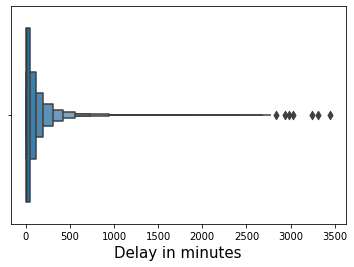

In [25]:
fig = sns.boxenplot(df['target'])
plt.xlabel("Delay in minutes", fontsize=15);


Now after we took a look at the distribution of the target variable, we should investigate the same distribution in numbers.  

In [10]:
df['target'].describe()

count    107833.000000
mean         48.733013
std         117.135562
min           0.000000
25%           0.000000
50%          14.000000
75%          43.000000
max        3451.000000
Name: target, dtype: float64

- far outliers
- Histogramm with lim at 75th percintile ???

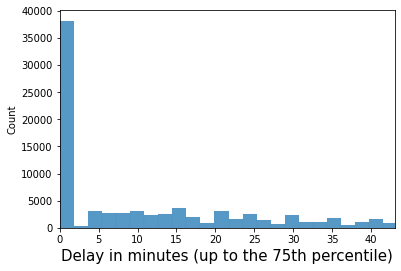

In [26]:
fig = sns.histplot(df.target)
plt.xlim(0, 43)
plt.xlabel("Delay in minutes (up to the 75th percentile)", fontsize=15);

Before we continue our EDA, we should establish a baseline model and engineer a few features to show the given information clearer. 

## Baseline Model

____

something about establishing a baseline ... 

## Feature Engineering
___


Our Datasets contains the IATA (International Air Transport Association) desiccation of the Airports but to build a good performing Model we need a bit more information. 
Gladly the needed data is publicly accessible.

In [12]:
def rename_ports() -> None:
    X['DEPSTN'] = X['DEPSTN'].mask(X['DEPSTN'] == 'SXF', 'BER')
    X['ARRSTN'] = X['ARRSTN'].mask(X['ARRSTN'] == 'SXF', 'BER')

In [13]:
def get_airport_data() -> None:
    arr = X.DEPSTN.unique()
    err_arr = []
    port_dict = {}
    for el in arr:
        try:
            port_dict[el] = tuple([airports[el].get(k) for k in ['lat', 'lon', 'elevation', 'country']])
        except KeyError:
            err_arr.append(el)

    X['airport_DEP'] = X['DEPSTN'].map(port_dict)

    print('Depart Coordinates')
    for err in err_arr: 
        print(f'{err} missing in Airportsdata: {X.DEPSTN.value_counts()[err]} rows affected')
    if not err_arr:
        print('    no missing Airportcodes in Airportdata')

    arr = X.ARRSTN.unique()
    err_arr = []
    port_dict = {}
    for el in arr:
        try:
            port_dict[el] = tuple([airports[el].get(k) for k in [ 'lat', 'lon', 'elevation', 'country']])
        except KeyError:
            err_arr.append(el)

    X['airport_ARR'] = X['ARRSTN'].map(port_dict)

    print('Arrival Coordinates')
    for err in err_arr: 
        print(f'{err} missing in Airportsdata: {X.ARRSTN.value_counts()[err]} rows affected')
    if not err_arr:
        print('    no missing Airportcodes in Airportdata')

In [14]:
def unpack_airport_data() -> None:
    pass

In [15]:
def convert_time_to_unix() -> None:

    pass
    #X['STA'] = pd.to_datetime(X['STA']).map(pd.Timestamp.timestamp)
    #X['STD'] = pd.to_datetime(X['STD']).map(pd.Timestamp.timestamp)

In [16]:
def get_time_literals() -> None:
    pass
    #X['Dep_weekday'] = pd.to_datetime(X['DATOP']).dt.strftime('%A')
    #X['flight_month'] = pd.to_datetime(X['DATOP']).dt.strftime('%b')

    #X['dep_hour'] = pd.to_datetime(X['STD']).dt.strftime('%H')
    #X['arr_hour'] = pd.to_datetime(X['STD']).dt.strftime('%H')  

In [17]:
def calc_duration() -> None:
    pass

In [18]:
def calc_distance() -> None:
    pass

In [19]:
def domestic_flight() -> None:
    pass 

In [20]:
def drop_rows() -> None:
    pass

feature_engineering = Pipeline([
    'rename_port', rename_ports(),
    'airport_data', get_airport_data(),
    'unpack_airport_data', unpack_airport_data(),
    'time_literals', get_time_literals(),
    'convert_time', convert_time_to_unix(),
    'duration', calc_duration(), 
    'distance', calc_distance(),
    'domestic', domestic_flight(), 
    'drop_rows', drop_rows()
])

feature_engineering

## Advanced EDA 
___

Lets take a look our new features ... 

## Preprocessing 
____

Split data into categorical and numerical features according to the datatype.

In [21]:
arr = X.columns

cat_feats = [x for x in arr if X[x].dtype == 'object']
numeric_feats = [x for x in arr if X[x].dtype == 'float64']

In [22]:
""" train/test split"""

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RSEED)

print ("Training set has {} samples.".format(X_train.shape[0]))
print ("Testing set has {} samples.".format(X_test.shape[0]))

Training set has 86266 samples.
Testing set has 21567 samples.


In [23]:
cat_pipe = Pipeline([
    ('1hot', OneHotEncoder(handle_unknown='ignore'))
])

num_pipe = Pipeline([
    ('std_scaler', StandardScaler())
])

In [28]:
preprocessor = ColumnTransformer([
    ('cat', cat_pipe, cat_feats), 
    ('num', num_pipe, numeric_feats)
])

## Training the baseline model

___

In [ ]:
pipe_base_model = Pipeline([
    ('preprocessor', preprocessor),
    ('basic_model', DecisionTreeRegressor())
])

In [ ]:
pipe_base_model.fit(X, y)

ValueError: A given column is not a column of the dataframe

In [ ]:
base_y_hat = pipe_base_model.predict(X_test)

AttributeError: 'ColumnTransformer' object has no attribute 'transformers_'

In [ ]:
print('_'*20)
print('Base Model:')
print("Mean Squared Error: {:.8f}".format(mean_squared_error(y_test, base_y_hat)))


## Using our new Features to improve our Model

____

In [ ]:
pipe_dectreereg = Pipeline([
    ('preprocessor', preprocessor),
    ('linreg', LinearRegression())
])

## Finding the best Hyperparameters

___

## Testing the Model 

___

## Conclusion 

___

#### Sources
___